Phase 1 Results:
Viable strategies: ['qEI', 'qGIBBON', 'qUCB']
Eliminated: {'Random'}

Phase 2 Results:
Robust strategies: []
Degradation scores: {}


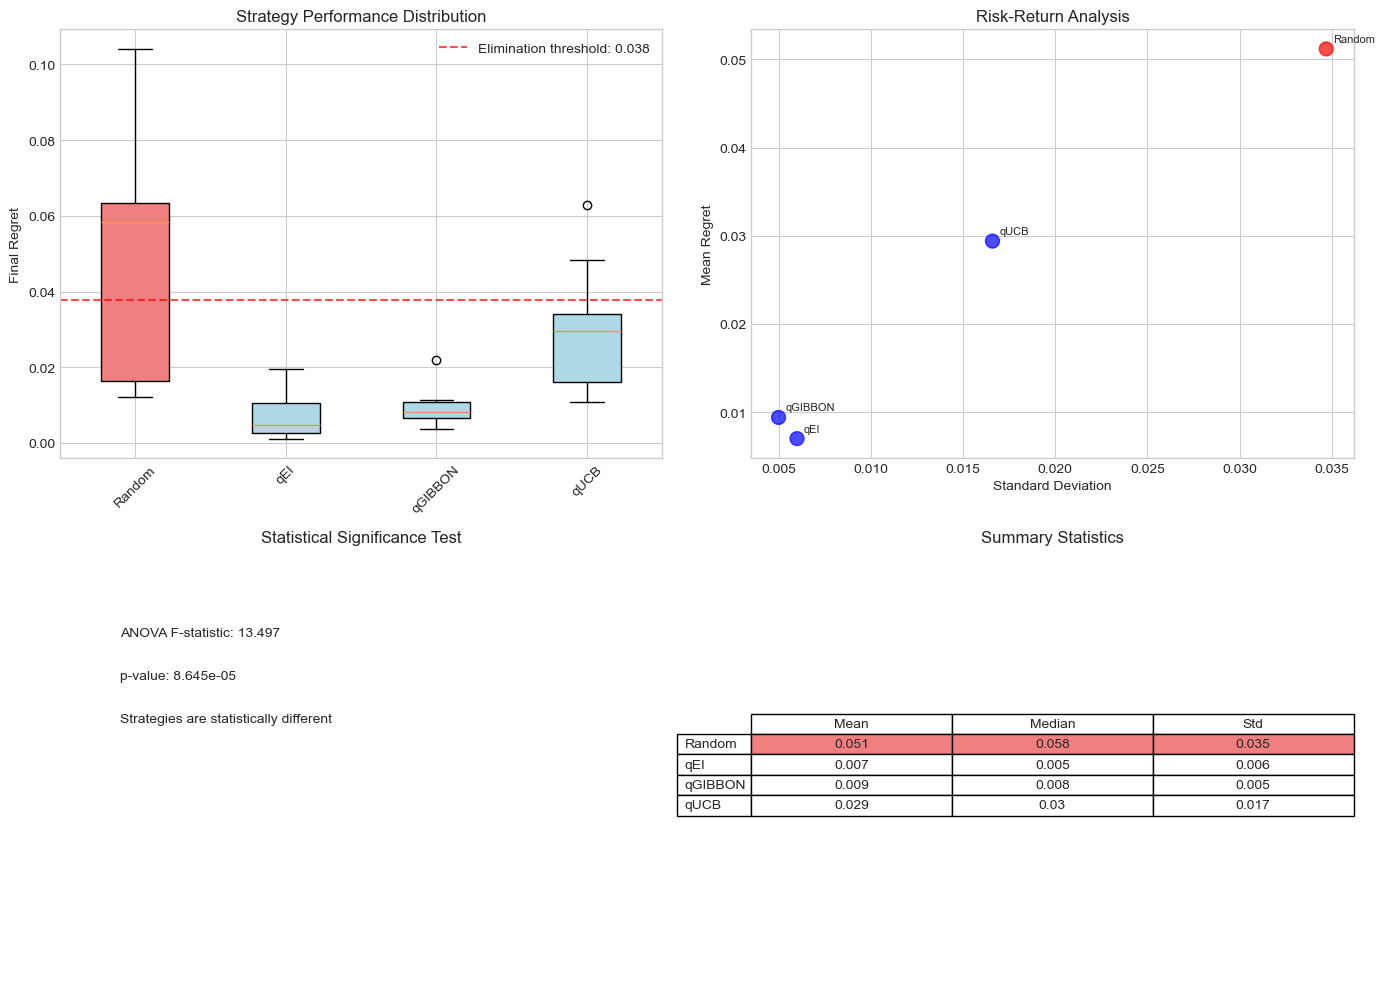

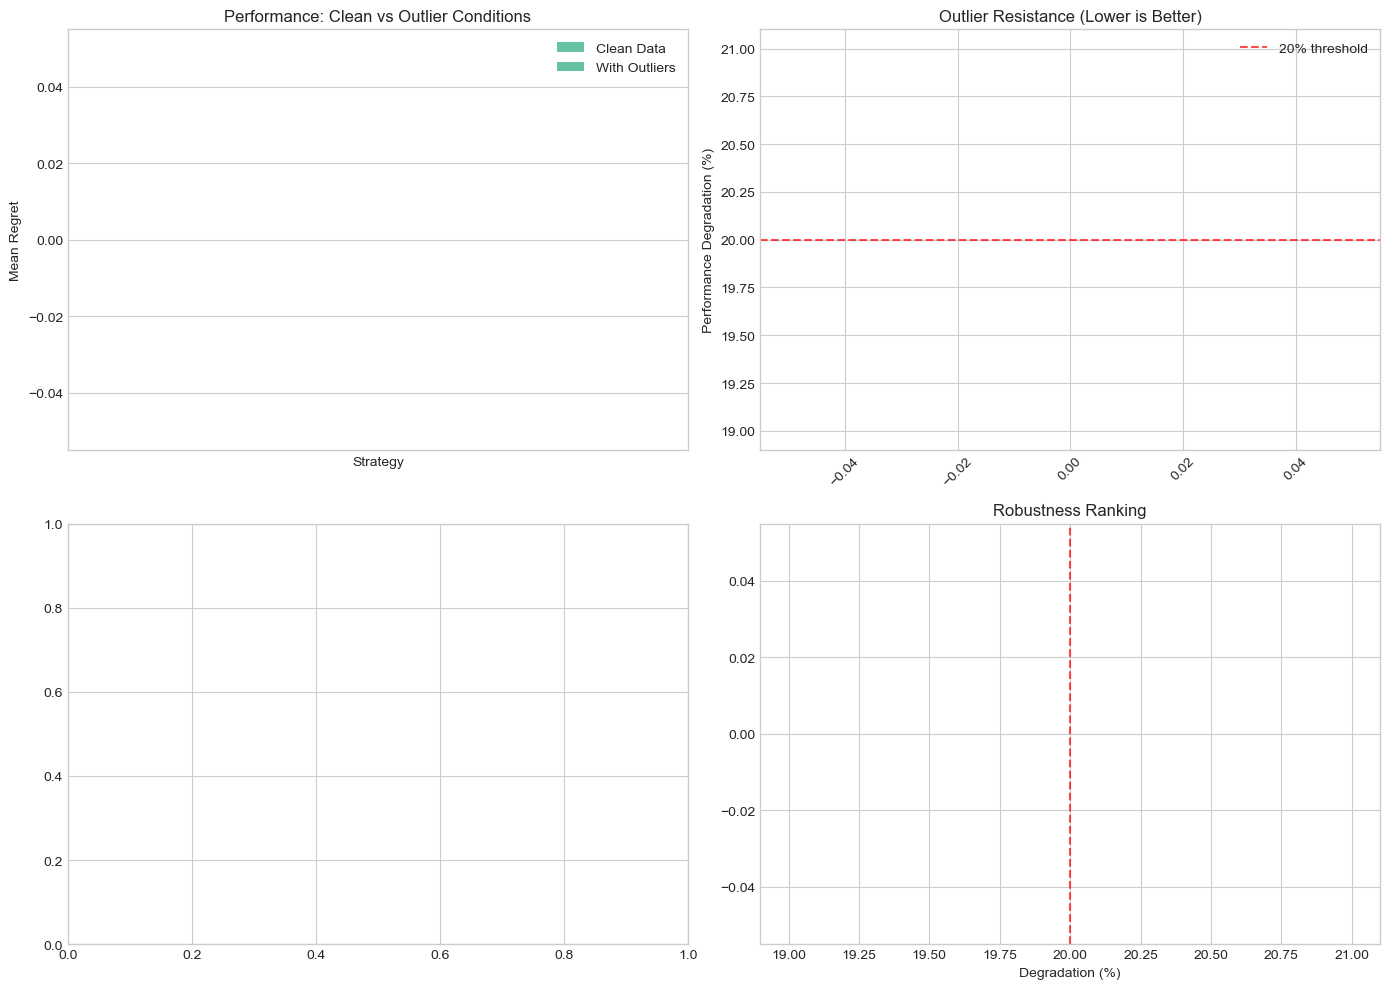

['iteration', 'acquisition_type', 'ground_truth_method', 'use_transfer_learning', 'prior_strength', 'outliers_enabled', 'outlier_fraction', 'outlier_type', 'outlier_magnitude', 'mse', 'rmse_h', 'r2', 'crps', 'coverage_high_region', 'posterior_mean', 'true_best', 'observed_best', 'true_value_at_best_observed', 'true_value_at_model_optimum', 'regret', 'exploitative_regret', 'CI_size_avg', 'coverage_95', 'seed', 'num_init', 'batch_size', 'noise_level', 'noise_strategy', 'gt_config']


In [6]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Set scientific plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

def load_and_clean_data(filename):
    """Load CSV with proper column cleaning"""
    df = pd.read_csv(filename, sep=';')
    df.columns = [col.strip().strip('"') for col in df.columns]
    return df

def phase1_elimination_analysis(df):
    """Phase 1: Statistical elimination of poor strategies"""
    
    # Get final regret per run
    final_regrets = df.groupby(['acquisition_type', 'seed'])['regret'].last().reset_index()
    
    # Statistical analysis
    strategy_stats = final_regrets.groupby('acquisition_type')['regret'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).round(4)
    
    # Elimination criteria
    median_threshold = strategy_stats['median'].median() * 2
    viable_strategies = strategy_stats[strategy_stats['median'] <= median_threshold].index
    
    return final_regrets, strategy_stats, viable_strategies

def create_elimination_plots(final_regrets, strategy_stats, viable_strategies):
    """Create publication-quality elimination plots"""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Boxplot with elimination threshold
    ax1 = axes[0, 0]
    box_data = [final_regrets[final_regrets['acquisition_type'] == strategy]['regret'].values 
                for strategy in strategy_stats.index]
    
    bp = ax1.boxplot(box_data, labels=strategy_stats.index, patch_artist=True)
    
    # Color viable vs eliminated
    for i, strategy in enumerate(strategy_stats.index):
        if strategy in viable_strategies:
            bp['boxes'][i].set_facecolor('lightblue')
        else:
            bp['boxes'][i].set_facecolor('lightcoral')
    
    threshold = strategy_stats['median'].median() * 2
    ax1.axhline(y=threshold, color='red', linestyle='--', alpha=0.7, label=f'Elimination threshold: {threshold:.3f}')
    ax1.set_ylabel('Final Regret')
    ax1.set_title('Strategy Performance Distribution')
    ax1.legend()
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: Mean vs Std scatter
    ax2 = axes[0, 1]
    colors = ['blue' if s in viable_strategies else 'red' for s in strategy_stats.index]
    scatter = ax2.scatter(strategy_stats['std'], strategy_stats['mean'], 
                         c=colors, alpha=0.7, s=100)
    
    for i, strategy in enumerate(strategy_stats.index):
        ax2.annotate(strategy, (strategy_stats['std'].iloc[i], strategy_stats['mean'].iloc[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax2.set_xlabel('Standard Deviation')
    ax2.set_ylabel('Mean Regret')
    ax2.set_title('Risk-Return Analysis')
    
    # Plot 3: Statistical significance test
    ax3 = axes[1, 0]
    
    # ANOVA test between strategies
    strategy_groups = [final_regrets[final_regrets['acquisition_type'] == s]['regret'].values 
                      for s in viable_strategies]
    
    if len(strategy_groups) > 1:
        f_stat, p_value = stats.f_oneway(*strategy_groups)
        ax3.text(0.1, 0.8, f'ANOVA F-statistic: {f_stat:.3f}', transform=ax3.transAxes)
        ax3.text(0.1, 0.7, f'p-value: {p_value:.3e}', transform=ax3.transAxes)
        ax3.text(0.1, 0.6, 'Strategies are statistically different' if p_value < 0.05 else 'No significant difference', 
                transform=ax3.transAxes)
    
    ax3.set_title('Statistical Significance Test')
    ax3.axis('off')
    
    # Plot 4: Summary statistics table
    ax4 = axes[1, 1]
    table_data = strategy_stats[['mean', 'median', 'std']].round(3)
    table = ax4.table(cellText=table_data.values,
                     rowLabels=table_data.index,
                     colLabels=['Mean', 'Median', 'Std'],
                     cellLoc='center',
                     loc='center')
    
    # Color table rows
    for i, strategy in enumerate(table_data.index):
        if strategy not in viable_strategies:
            for j in range(len(table_data.columns)):
                table[(i+1, j)].set_facecolor('lightcoral')
    
    ax4.set_title('Summary Statistics')
    ax4.axis('off')
    
    plt.tight_layout()
    return fig

def phase2_outlier_analysis(df, viable_strategies):
    """Phase 2: Outlier resistance analysis"""
    
    df_viable = df[df['acquisition_type'].isin(viable_strategies)]
    
    # Performance with and without outliers
    outlier_comparison = df_viable.groupby(['acquisition_type', 'outliers_enabled'])['regret'].agg([
        'mean', 'median', 'std'
    ]).round(4)
    
    # Calculate degradation scores
    degradation_scores = {}
    
    for strategy in viable_strategies:
        clean_data = df_viable[(df_viable['acquisition_type'] == strategy) & 
                              (df_viable['outliers_enabled'] == False)]
        outlier_data = df_viable[(df_viable['acquisition_type'] == strategy) & 
                                (df_viable['outliers_enabled'] == True)]
        
        if len(clean_data) > 0 and len(outlier_data) > 0:
            clean_mean = clean_data['regret'].mean()
            outlier_mean = outlier_data['regret'].mean()
            degradation = (outlier_mean - clean_mean) / clean_mean if clean_mean > 0 else np.inf
            degradation_scores[strategy] = degradation
    
    # Filter robust strategies (< 20% degradation)
    robust_strategies = [s for s, deg in degradation_scores.items() if deg < 0.2]
    
    return outlier_comparison, degradation_scores, robust_strategies

def create_outlier_plots(df_viable, degradation_scores, robust_strategies):
    """Create outlier resistance plots"""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Before/After outlier comparison
    ax1 = axes[0, 0]
    
    strategies = list(degradation_scores.keys())
    clean_means = []
    outlier_means = []
    
    for strategy in strategies:
        clean_mean = df_viable[(df_viable['acquisition_type'] == strategy) & 
                              (df_viable['outliers_enabled'] == False)]['regret'].mean()
        outlier_mean = df_viable[(df_viable['acquisition_type'] == strategy) & 
                                (df_viable['outliers_enabled'] == True)]['regret'].mean()
        clean_means.append(clean_mean)
        outlier_means.append(outlier_mean)
    
    x = np.arange(len(strategies))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, clean_means, width, label='Clean Data', alpha=0.8)
    bars2 = ax1.bar(x + width/2, outlier_means, width, label='With Outliers', alpha=0.8)
    
    ax1.set_xlabel('Strategy')
    ax1.set_ylabel('Mean Regret')
    ax1.set_title('Performance: Clean vs Outlier Conditions')
    ax1.set_xticks(x)
    ax1.set_xticklabels(strategies, rotation=45)
    ax1.legend()
    
    # Plot 2: Degradation scores
    ax2 = axes[0, 1]
    
    colors = ['green' if s in robust_strategies else 'red' for s in strategies]
    bars = ax2.bar(strategies, [degradation_scores[s] * 100 for s in strategies], 
                   color=colors, alpha=0.7)
    
    ax2.axhline(y=20, color='red', linestyle='--', alpha=0.7, label='20% threshold')
    ax2.set_ylabel('Performance Degradation (%)')
    ax2.set_title('Outlier Resistance (Lower is Better)')
    ax2.tick_params(axis='x', rotation=45)
    ax2.legend()
    
    # Plot 3: Violin plots showing distribution changes
    ax3 = axes[1, 0]
    
    # Prepare data for violin plot
    plot_data = []
    plot_labels = []
    
    for strategy in strategies:
        clean_data = df_viable[(df_viable['acquisition_type'] == strategy) & 
                              (df_viable['outliers_enabled'] == False)]['regret'].values
        outlier_data = df_viable[(df_viable['acquisition_type'] == strategy) & 
                                (df_viable['outliers_enabled'] == True)]['regret'].values
        
        if len(clean_data) > 0:
            plot_data.append(clean_data)
            plot_labels.append(f'{strategy}_clean')
        if len(outlier_data) > 0:
            plot_data.append(outlier_data)
            plot_labels.append(f'{strategy}_outlier')
    
    if plot_data:
        violin_parts = ax3.violinplot(plot_data, positions=range(len(plot_data)))
        ax3.set_xticks(range(len(plot_data)))
        ax3.set_xticklabels(plot_labels, rotation=90)
        ax3.set_ylabel('Regret')
        ax3.set_title('Distribution Shape Changes')
    
    # Plot 4: Robustness ranking
    ax4 = axes[1, 1]
    
    sorted_strategies = sorted(degradation_scores.items(), key=lambda x: x[1])
    strategy_names = [s[0] for s in sorted_strategies]
    degradation_values = [s[1] * 100 for s in sorted_strategies]
    
    colors = ['green' if s[0] in robust_strategies else 'red' for s in sorted_strategies]
    
    bars = ax4.barh(strategy_names, degradation_values, color=colors, alpha=0.7)
    ax4.axvline(x=20, color='red', linestyle='--', alpha=0.7)
    ax4.set_xlabel('Degradation (%)')
    ax4.set_title('Robustness Ranking')
    
    plt.tight_layout()
    return fig

# Usage example:
def run_scientific_analysis(filename):
    """Run complete scientific analysis pipeline"""
    
    # Load data
    df = load_and_clean_data(filename)
    
    # Phase 1: Elimination
    final_regrets, strategy_stats, viable_strategies = phase1_elimination_analysis(df)
    fig1 = create_elimination_plots(final_regrets, strategy_stats, viable_strategies)
    
    print("Phase 1 Results:")
    print(f"Viable strategies: {list(viable_strategies)}")
    print(f"Eliminated: {set(strategy_stats.index) - set(viable_strategies)}")
    
    # Phase 2: Outlier analysis
    outlier_comparison, degradation_scores, robust_strategies = phase2_outlier_analysis(df, viable_strategies)
    fig2 = create_outlier_plots(df[df['acquisition_type'].isin(viable_strategies)], 
                                degradation_scores, robust_strategies)
    
    print("\nPhase 2 Results:")
    print(f"Robust strategies: {robust_strategies}")
    print("Degradation scores:", {k: f"{v:.1%}" for k, v in degradation_scores.items()})
    
    return fig1, fig2, robust_strategies

# Run analysis
fig1, fig2, final_strategies = run_scientific_analysis('bo_all_metrics_mc_standard_UCB4.csv')
plt.show()
# print all columns of dataset
df = load_and_clean_data('bo_all_metrics_mc_standard_UCB4.csv')
print(df.columns.tolist())


SyntaxError: invalid syntax (1126211428.py, line 1)

Loaded data: (3520, 29)
Available columns: ['iteration', 'acquisition_type', 'ground_truth_method', 'use_transfer_learning', 'prior_strength', 'outliers_enabled', 'outlier_fraction', 'outlier_type', 'outlier_magnitude', 'mse', 'rmse_h', 'r2', 'crps', 'coverage_high_region', 'posterior_mean', 'true_best', 'observed_best', 'true_value_at_best_observed', 'true_value_at_model_optimum', 'regret', 'exploitative_regret', 'CI_size_avg', 'coverage_95', 'seed', 'num_init', 'batch_size', 'noise_level', 'noise_strategy', 'gt_config']
Unique acquisition types: ['qUCB' 'qEI' 'Random' 'qGIBBON']
Unique num_init values: [ 5 10 20]
=== PHASE 1: INITIAL ELIMINATION ===

Baseline data: 3430 rows
Final regrets calculated for 120 runs
Unique strategies: 12

Elimination threshold: 0.0319 (2x global median: 0.0159)

📊 STRATEGY PERFORMANCE:
------------------------------------------------------------
qEI_init5            | Median: 0.0070 ✅ | Runs: 10 ✅ | VIABLE
qGIBBON_init5        | Median: 0.0079 ✅ | Runs: 

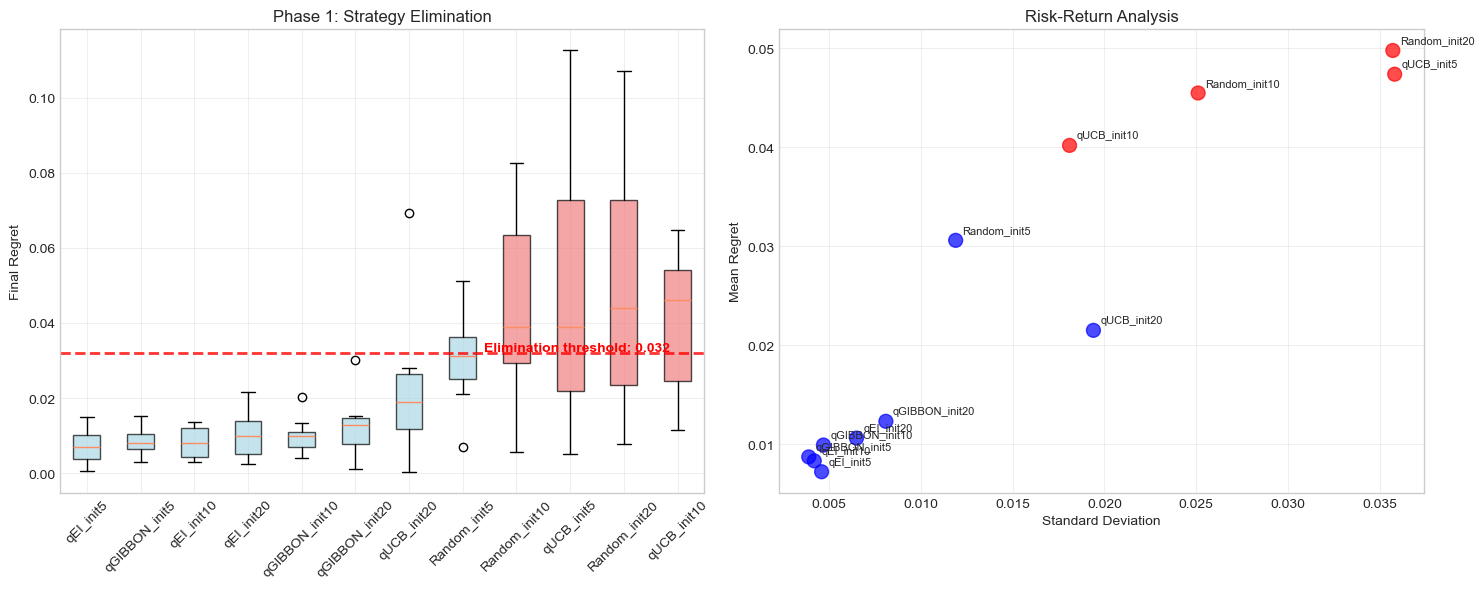


🏆 PHASE 1 COMPLETE
Surviving strategies: 8
Ready for Phase 2 analysis


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def phase1_elimination(df, elimination_threshold=2.0, min_success_rate=0.7):
   """
   Phase 1: Quick elimination of obviously poor strategies
   """
   
   print("=== PHASE 1: INITIAL ELIMINATION ===\n")
   
   # Filter to clean baseline conditions
   baseline_data = df[
       (df['outliers_enabled'] == False) & 
       (df['use_transfer_learning'] == False)
   ].copy()
   
   if len(baseline_data) == 0:
       print("No baseline data found. Using all data.")
       baseline_data = df.copy()
   
   print(f"Baseline data: {len(baseline_data)} rows")
   
   # Create strategy identifier
   baseline_data['strategy'] = baseline_data['acquisition_type'] + '_init' + baseline_data['num_init'].astype(str)
   
   # Get final regret per run (last iteration per seed/strategy)
   final_regrets = baseline_data.groupby(['strategy', 'seed'])['regret'].last().reset_index()
   
   print(f"Final regrets calculated for {len(final_regrets)} runs")
   print(f"Unique strategies: {final_regrets['strategy'].nunique()}")
   
   # Calculate strategy statistics
   strategy_stats = final_regrets.groupby('strategy')['regret'].agg([
       'count', 'mean', 'median', 'std', 'min', 'max'
   ]).round(4)
   
   strategy_stats.columns = ['n_runs', 'mean_regret', 'median_regret', 'std_regret', 'min_regret', 'max_regret']
   
   # Elimination criteria
   global_median = strategy_stats['median_regret'].median()
   threshold = global_median * elimination_threshold
   
   print(f"\nElimination threshold: {threshold:.4f} (2x global median: {global_median:.4f})")
   
   # Apply elimination criteria
   # 1. Performance criterion
   performance_viable = strategy_stats['median_regret'] <= threshold
   
   # 2. Success rate criterion (assume all converged if we have final regrets)
   success_rates = strategy_stats['n_runs'] / strategy_stats['n_runs'].max()
   success_viable = success_rates >= min_success_rate
   
   # Combined viability
   viable_strategies = strategy_stats[performance_viable & success_viable].index.tolist()
   eliminated_strategies = strategy_stats[~(performance_viable & success_viable)].index.tolist()
   
   # Results summary
   print(f"\n📊 STRATEGY PERFORMANCE:")
   print("-" * 60)
   for strategy in strategy_stats.sort_values('median_regret').index:
       perf_status = "✅" if performance_viable[strategy] else "❌"
       success_status = "✅" if success_viable[strategy] else "❌"
       overall_status = "VIABLE" if strategy in viable_strategies else "ELIMINATED"
       
       print(f"{strategy:20} | Median: {strategy_stats.loc[strategy, 'median_regret']:.4f} {perf_status} | "
             f"Runs: {strategy_stats.loc[strategy, 'n_runs']:2d} {success_status} | {overall_status}")
   
   print(f"\n🎯 ELIMINATION RESULTS:")
   print(f"Threshold: {threshold:.4f}")
   print(f"Viable strategies: {len(viable_strategies)}")
   print(f"Eliminated strategies: {len(eliminated_strategies)}")
   print(f"Viable: {viable_strategies}")
   print(f"Eliminated: {eliminated_strategies}")
   
   # Create elimination plot
   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
   
   # Plot 1: Boxplot with threshold
   strategy_order = strategy_stats.sort_values('median_regret').index
   box_data = [final_regrets[final_regrets['strategy'] == s]['regret'].values for s in strategy_order]
   
   bp = ax1.boxplot(box_data, labels=strategy_order, patch_artist=True)
   
   # Color boxes
   for i, strategy in enumerate(strategy_order):
       if strategy in viable_strategies:
           bp['boxes'][i].set_facecolor('lightblue')
           bp['boxes'][i].set_alpha(0.7)
       else:
           bp['boxes'][i].set_facecolor('lightcoral')
           bp['boxes'][i].set_alpha(0.7)
   
   ax1.axhline(y=threshold, color='red', linestyle='--', alpha=0.8, linewidth=2)
   ax1.text(len(strategy_order) * 0.7, threshold * 1.02, f'Elimination threshold: {threshold:.3f}', 
            color='red', fontweight='bold')
   
   ax1.set_ylabel('Final Regret')
   ax1.set_title('Phase 1: Strategy Elimination')
   ax1.tick_params(axis='x', rotation=45)
   ax1.grid(True, alpha=0.3)
   
   # Plot 2: Performance summary
   colors = ['blue' if s in viable_strategies else 'red' for s in strategy_stats.index]
   
   ax2.scatter(strategy_stats['std_regret'], strategy_stats['mean_regret'], 
               c=colors, alpha=0.7, s=100)
   
   for strategy in strategy_stats.index:
       ax2.annotate(strategy, 
                   (strategy_stats.loc[strategy, 'std_regret'], 
                    strategy_stats.loc[strategy, 'mean_regret']),
                   xytext=(5, 5), textcoords='offset points', fontsize=8)
   
   ax2.set_xlabel('Standard Deviation')
   ax2.set_ylabel('Mean Regret')
   ax2.set_title('Risk-Return Analysis')
   ax2.grid(True, alpha=0.3)
   
   plt.tight_layout()
   plt.show()
   
   # Return results
   results = {
       'viable_strategies': viable_strategies,
       'eliminated_strategies': eliminated_strategies,
       'strategy_stats': strategy_stats,
       'final_regrets': final_regrets,
       'threshold': threshold,
       'elimination_plot': fig
   }
   
   return results

# Usage
def run_phase1_analysis(csv_file):
   """Run Phase 1 analysis from CSV file"""
   
   # Load data
   df = pd.read_csv(csv_file, sep=';')
   df.columns = [col.strip().strip('"') for col in df.columns]
   
   print(f"Loaded data: {df.shape}")
   print(f"Available columns: {list(df.columns)}")
   print(f"Unique acquisition types: {df['acquisition_type'].unique()}")
   print(f"Unique num_init values: {df['num_init'].unique()}")
   
   # Run Phase 1
   phase1_results = phase1_elimination(df)
   
   return phase1_results

# Execute
if __name__ == "__main__":
   phase1_results = run_phase1_analysis('bo_all_metrics_mc_standard_UCB2.csv')
   
   print(f"\n🏆 PHASE 1 COMPLETE")
   print(f"Surviving strategies: {len(results['viable_strategies'])}")
   print(f"Ready for Phase 2 analysis")


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def phase2_efficiency_analysis(df, phase1_survivors, min_convergence_rate=0.7, efficiency_threshold=0.15):
   """
   Phase 2: Efficiency and practicality assessment
   Focus: Initial points efficiency, convergence reliability, cost-benefit
   """
   
   print("=== PHASE 2: EFFICIENCY & PRACTICALITY ANALYSIS ===\n")
   
   # Filter to phase 1 survivors
   df_survivors = df[df.apply(lambda row: f"{row['acquisition_type']}_init{row['num_init']}" in phase1_survivors, axis=1)].copy()
   df_survivors['strategy'] = df_survivors['acquisition_type'] + '_init' + df_survivors['num_init'].astype(str)
   
   print(f"Analyzing {len(phase1_survivors)} surviving strategies")
   print(f"Data points: {len(df_survivors)} rows")
   
   # Analyze efficiency metrics
   efficiency_results = {}
   
   for strategy in phase1_survivors:
       strategy_data = df_survivors[df_survivors['strategy'] == strategy]
       
       if len(strategy_data) == 0:
           continue
       
       # Extract acquisition type and init points
       acq_type = strategy.split('_init')[0]
       init_points = int(strategy.split('_init')[1])
       
       # 1. Convergence Analysis
       final_regrets = strategy_data.groupby('seed')['regret'].last()
       n_seeds = len(final_regrets.unique()) if 'seed' in strategy_data.columns else len(strategy_data) // 20  # Estimate
       
       # Assume convergence if final regret is reasonable (< 2x median of all survivors)
       all_final_regrets = df_survivors.groupby(['strategy', 'seed'])['regret'].last() if 'seed' in df_survivors.columns else df_survivors['regret']
       convergence_threshold = all_final_regrets.median() * 2
       converged_runs = (final_regrets < convergence_threshold).sum() if len(final_regrets) > 0 else 0
       convergence_rate = converged_runs / len(final_regrets) if len(final_regrets) > 0 else 0
       
       # 2. Performance Metrics
       mean_regret = strategy_data['regret'].mean()
       std_regret = strategy_data['regret'].std()
       
       # 3. Efficiency Metrics
       # Estimate total experiments (initial + BO iterations)
       if 'iteration' in strategy_data.columns:
           max_iterations = strategy_data['iteration'].max()
           median_iterations = strategy_data['iteration'].median()
           total_experiments = init_points + median_iterations
       else:
           # Fallback estimation
           total_experiments = init_points + 15  # Assume ~15 BO iterations
           max_iterations = 20
       
       # 4. Cost-Benefit Analysis
       # Compare to baseline (smallest init points for same acquisition function)
       baseline_candidates = [s for s in phase1_survivors if s.startswith(acq_type + '_init')]
       if baseline_candidates:
           baseline_init = min([int(s.split('_init')[1]) for s in baseline_candidates])
           extra_init_cost = init_points - baseline_init
       else:
           extra_init_cost = 0
       
       efficiency_results[strategy] = {
           'acquisition_type': acq_type,
           'init_points': init_points,
           'convergence_rate': convergence_rate,
           'mean_regret': mean_regret,
           'std_regret': std_regret,
           'total_experiments': total_experiments,
           'max_iterations': max_iterations,
           'extra_init_cost': extra_init_cost,
           'n_runs': len(final_regrets)
       }
   
   # Convert to DataFrame for easier analysis
   efficiency_df = pd.DataFrame(efficiency_results).T
   efficiency_df.index.name = 'strategy'
   
   print("📊 EFFICIENCY ANALYSIS:")
   print("-" * 80)
   print(f"{'Strategy':<20} | {'Conv.Rate':<9} | {'Mean Regret':<11} | {'Total Exp.':<10} | {'Status'}")
   print("-" * 80)
   
   # Apply efficiency criteria
   viable_phase2 = []
   eliminated_phase2 = []
   
   for strategy, row in efficiency_df.iterrows():
       # Criterion 1: Convergence rate
       conv_viable = row['convergence_rate'] >= min_convergence_rate
       
       # Criterion 2: Efficiency check - is extra cost justified?
       acq_type = row['acquisition_type']
       
       # Compare within acquisition function family
       same_acq_strategies = efficiency_df[efficiency_df['acquisition_type'] == acq_type]
       if len(same_acq_strategies) > 1:
           # Check if higher init points give significant improvement
           sorted_by_init = same_acq_strategies.sort_values('init_points')
           
           if len(sorted_by_init) >= 2:
               performance_improvement = (sorted_by_init.iloc[0]['mean_regret'] - row['mean_regret']) / sorted_by_init.iloc[0]['mean_regret']
               cost_increase = (row['total_experiments'] - sorted_by_init.iloc[0]['total_experiments']) / sorted_by_init.iloc[0]['total_experiments']
               
               # Efficiency: improvement should be at least 15% of cost increase
               efficiency_ratio = performance_improvement / cost_increase if cost_increase > 0 else float('inf')
               efficiency_viable = efficiency_ratio >= efficiency_threshold or row['init_points'] <= sorted_by_init.iloc[0]['init_points']
           else:
               efficiency_viable = True
       else:
           efficiency_viable = True
       
       # Combined assessment
       if conv_viable and efficiency_viable:
           viable_phase2.append(strategy)
           status = "✅ VIABLE"
       else:
           eliminated_phase2.append(strategy)
           reasons = []
           if not conv_viable:
               reasons.append("Low convergence")
           if not efficiency_viable:
               reasons.append("Inefficient")
           status = f"❌ ELIMINATED ({', '.join(reasons)})"
       
       print(f"{strategy:<20} | {row['convergence_rate']:<9.1%} | {row['mean_regret']:<11.4f} | {row['total_experiments']:<10.0f} | {status}")
   
   print(f"\n🎯 PHASE 2 RESULTS:")
   print(f"Convergence threshold: {min_convergence_rate:.1%}")
   print(f"Efficiency threshold: {efficiency_threshold:.1%}")
   print(f"Viable strategies: {len(viable_phase2)}")
   print(f"Eliminated strategies: {len(eliminated_phase2)}")
   print(f"Surviving: {viable_phase2}")
   print(f"Eliminated: {eliminated_phase2}")
   
   # Create efficiency plots
   fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
   
   # Plot 1: Convergence Rate vs Performance
   colors = ['green' if s in viable_phase2 else 'red' for s in efficiency_df.index]
   scatter = ax1.scatter(efficiency_df['convergence_rate'], efficiency_df['mean_regret'], 
                        c=colors, alpha=0.7, s=100)
   
   for strategy in efficiency_df.index:
       ax1.annotate(strategy, 
                   (efficiency_df.loc[strategy, 'convergence_rate'], 
                    efficiency_df.loc[strategy, 'mean_regret']),
                   xytext=(5, 5), textcoords='offset points', fontsize=8)
   
   ax1.axvline(x=min_convergence_rate, color='red', linestyle='--', alpha=0.7)
   ax1.set_xlabel('Convergence Rate')
   ax1.set_ylabel('Mean Regret')
   ax1.set_title('Convergence vs Performance')
   ax1.grid(True, alpha=0.3)
   
   # Plot 2: Total Experiments vs Performance
   ax2.scatter(efficiency_df['total_experiments'], efficiency_df['mean_regret'], 
              c=colors, alpha=0.7, s=100)
   
   for strategy in efficiency_df.index:
       ax2.annotate(strategy, 
                   (efficiency_df.loc[strategy, 'total_experiments'], 
                    efficiency_df.loc[strategy, 'mean_regret']),
                   xytext=(5, 5), textcoords='offset points', fontsize=8)
   
   ax2.set_xlabel('Total Experiments')
   ax2.set_ylabel('Mean Regret')
   ax2.set_title('Cost vs Performance')
   ax2.grid(True, alpha=0.3)
   
   # Plot 3: Initial Points Efficiency by Acquisition Function
   for acq_type in efficiency_df['acquisition_type'].unique():
       acq_data = efficiency_df[efficiency_df['acquisition_type'] == acq_type]
       ax3.plot(acq_data['init_points'], acq_data['mean_regret'], 'o-', 
               label=acq_type, alpha=0.7, linewidth=2, markersize=8)
   
   ax3.set_xlabel('Initial Points')
   ax3.set_ylabel('Mean Regret')
   ax3.set_title('Initial Points Efficiency by Acquisition Function')
   ax3.legend()
   ax3.grid(True, alpha=0.3)
   
   # Plot 4: Cost-Benefit Analysis
   efficiency_df['efficiency_score'] = 1 / (1 + efficiency_df['total_experiments']) + 1 / (1 + efficiency_df['mean_regret'])
   
   bars = ax4.barh(range(len(efficiency_df)), efficiency_df['efficiency_score'], 
                  color=colors, alpha=0.7)
   ax4.set_yticks(range(len(efficiency_df)))
   ax4.set_yticklabels(efficiency_df.index)
   ax4.set_xlabel('Efficiency Score (Higher = Better)')
   ax4.set_title('Overall Efficiency Ranking')
   ax4.grid(True, alpha=0.3, axis='x')
   
   plt.tight_layout()
   plt.show()
   
   # Return results for Phase 3
   phase2_results = {
       'viable_strategies': viable_phase2,
       'eliminated_strategies': eliminated_phase2,
       'efficiency_df': efficiency_df,
       'convergence_threshold': min_convergence_rate,
       'efficiency_threshold': efficiency_threshold,
       'plots': fig
   }
   
   return phase2_results

# Usage function
def run_phase2_analysis(df, phase1_results):
   """Run Phase 2 analysis with Phase 1 survivors"""
   
   phase1_survivors = phase1_results['viable_strategies']
   phase2_results = phase2_efficiency_analysis(df, phase1_survivors)
   
   return phase2_results

# Example usage:
phase2_results = run_phase2_analysis(df, phase1_results)

NameError: name 'phase1_results' is not defined